In [ ]:
import pandas as pd
customer_df = pd.read_csv("dataset\raw_dataset.csv")
customer_df

Using Colab cache for faster access to the 'telco-customer-churn' dataset.
Path to dataset files: /kaggle/input/telco-customer-churn


In [5]:
customer_df.isna().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [6]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

label = LabelEncoder()
customer_df['gender_LE'] = label.fit_transform(customer_df['gender'])
customer_df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender_LE
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.5,No,1
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,1
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No,1
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No,0
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No,0
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes,1


In [7]:
print(customer_df['gender'].value_counts(dropna=False))
print(customer_df['Churn'].value_counts(dropna=False))

gender
Male      3555
Female    3488
Name: count, dtype: int64
Churn
No     5174
Yes    1869
Name: count, dtype: int64


## Here considering gender and churn which are categorical

H0: independent
H1: dependent

In [8]:
table = pd.crosstab(customer_df['gender'], customer_df['Churn'])
table

Churn,No,Yes
gender,,
Female,2549,939
Male,2625,930


In [9]:
from scipy.stats import chi2_contingency, fisher_exact, levene

chi2_churn, p_churn, dof_churn, expected_churn = chi2_contingency(table)
print("Chi square:", chi2_churn, "P Value:", p_churn, "Dof:", dof_churn)
print("Expected counts if independent:", expected_churn)

Chi square: 0.4840828822091383 P Value: 0.48657873605618596 Dof: 1
Expected counts if independent: [[2562.38989067  925.61010933]
 [2611.61010933  943.38989067]]


In [10]:
print("Gender is asscociated with churn:", p_churn<0.05)

Gender is asscociated with churn: False


### Using Cramer's V association strength

In [11]:
def cramersV(chi2, n, r, c):
  return np.sqrt(chi2/ (n* min(r-1, c-1)))

n_churn = table.to_numpy().sum()
r_churn, c_churn = table.shape

V_churn = cramersV(chi2_churn, n_churn, r_churn, c_churn)
print("Cramer's V:", V_churn)

Cramer's V: 0.008290505631771371


In [12]:
obs = table.values
std_residuals = (obs - expected_churn) / np.sqrt(expected_churn)
resid_df = pd.DataFrame(std_residuals, index=table.index,
                        columns=table.columns)
resid_df

Churn,No,Yes
gender,,
Female,-0.264518,0.440112
Male,0.262013,-0.435945


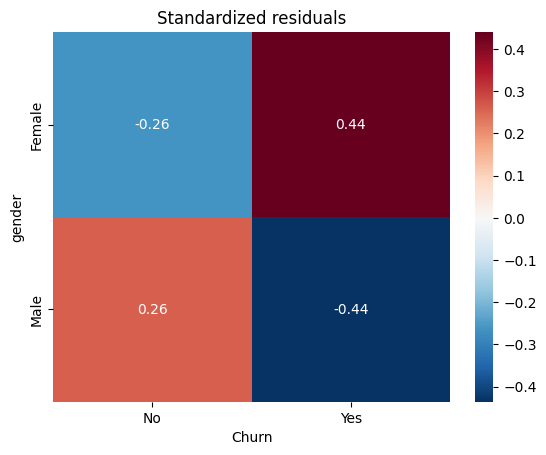

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(resid_df, annot=True, center=0, cmap="RdBu_r")
plt.title("Standardized residuals")
plt.show()

## Numerical vs Categorical

In [14]:
customer_df['Churn'].head()

,Churn
0,No
1,No
2,Yes
3,No
4,Yes


In [15]:
from scipy.stats import levene, ttest_ind

group_yes = customer_df[customer_df["Churn"] == "Yes"]["MonthlyCharges"].dropna()
group_no = customer_df[customer_df["Churn"] == "No"]["MonthlyCharges"].dropna()


stat_levene, p_levene = levene(group_yes, group_no, center='median')
print("Stat levene:", stat_levene)
print("P levene:", p_levene)
print("Reject the null hypothesis of churn independent on monthly charges:", p_levene < 0.05)

Stat levene: 361.8444859598828
P levene: 1.0261244899421871e-78
Reject the null hypothesis of churn independent on monthly charges: True


In [16]:
customer_df['churn bin'] = customer_df["Churn"].map({"Yes": 1, "No": 0})

In [17]:
customer_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender_LE,churn bin
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,One year,No,Mailed check,56.95,1889.5,No,1,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,1,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0,1


In [18]:
customer_df.describe()

,SeniorCitizen,tenure,MonthlyCharges,gender_LE,churn bin
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,0.504756,0.265370
std,0.368612,24.559481,30.090047,0.500013,0.441561
min,0.000000,0.000000,18.250000,0.000000,0.000000
25%,0.000000,9.000000,35.500000,0.000000,0.000000
50%,0.000000,29.000000,70.350000,1.000000,0.000000
75%,0.000000,55.000000,89.850000,1.000000,1.000000
max,1.000000,72.000000,118.750000,1.000000,1.000000


In [19]:
print(customer_df.groupby("Churn")['MonthlyCharges'].agg(['count', 'mean', 'std', 'median']).round(3))

       count    mean     std  median
Churn                               
No      5174  61.265  31.093  64.425
Yes     1869  74.441  24.666  79.650


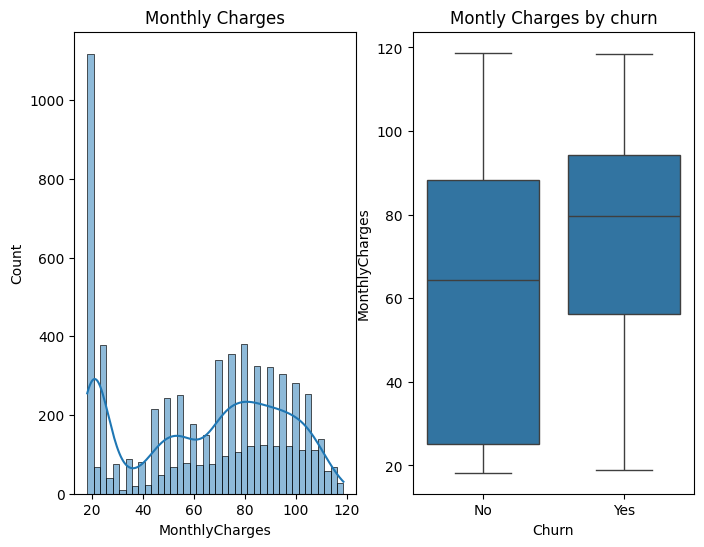

In [20]:
plt.figure(figsize=(8,6))
plt.subplot(1,2,1)
sns.histplot(customer_df['MonthlyCharges'].dropna(), kde=True, bins=40)
plt.title("Monthly Charges")

plt.subplot(1,2,2)
sns.boxplot(x='Churn', y="MonthlyCharges", data=customer_df)
plt.title("Montly Charges by churn")

plt.show()

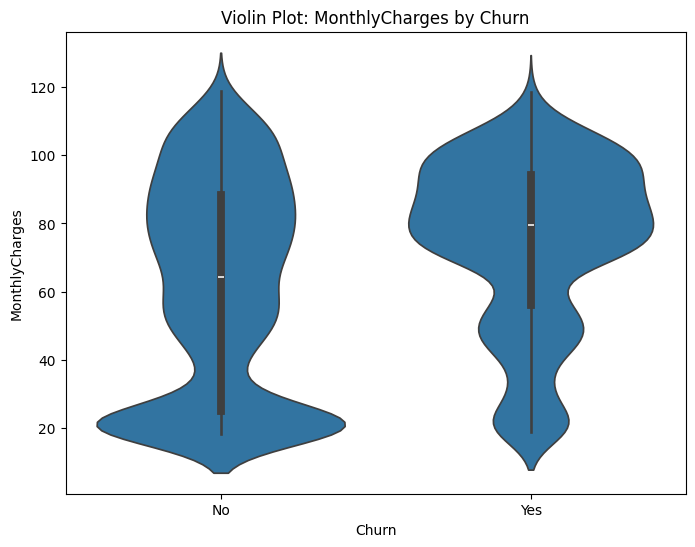

In [21]:
plt.figure(figsize=(8,6))
sns.violinplot(x="Churn", y="MonthlyCharges", data=customer_df)
plt.title("Violin Plot: MonthlyCharges by Churn")
plt.show()

### ECDF

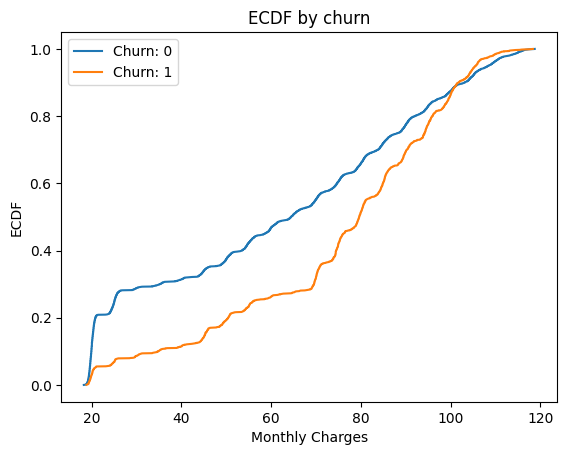

In [22]:
def ecdf(data):
  x = np.sort(data)
  y = np.arange(1, len(x)+1)/len(x)
  return x, y

for label in [0, 1]:
  x, y = ecdf(customer_df.loc[customer_df['churn bin']==label, 'MonthlyCharges'].dropna())
  plt.plot(x,y, label=f"Churn: {label}")

plt.xlabel("Monthly Charges")
plt.ylabel("ECDF")
plt.legend()
plt.title("ECDF by churn")
plt.show()

In [23]:
print("Missing values:", customer_df['MonthlyCharges'].isna().sum())

Missing values: 0


In [24]:
q1, q3 = customer_df['MonthlyCharges'].quantile([0.25, 0.75])
q1, q3

(35.5, 89.85)

In [25]:
iqr = q3 - q1
lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
lower, upper

(-46.02499999999999, 171.375)

### Check for normality and Variance equality

In [26]:
group_yes = customer_df[customer_df["churn bin"]==1]['MonthlyCharges'].dropna()
group_no = customer_df[customer_df['churn bin']==0]['MonthlyCharges'].dropna()

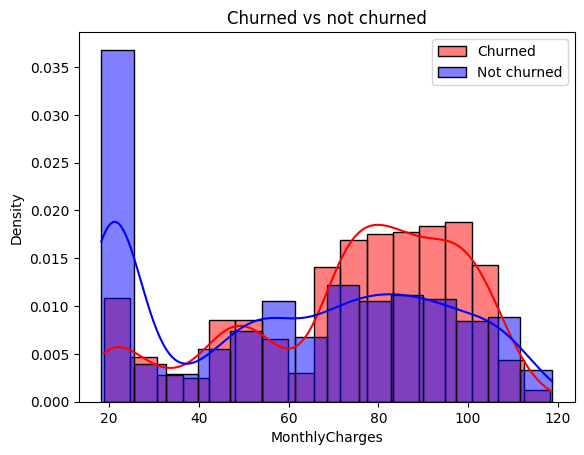

In [27]:
sns.histplot(group_yes, kde=True, stat='density', color='red', label='Churned')
sns.histplot(group_no, kde=True, stat='density', color='blue', label='Not churned')
plt.title("Churned vs not churned")
plt.legend()
plt.show()

In [28]:
from scipy.stats import shapiro, skew
if len(group_yes) < 5000 and len(group_no) < 5000:
  print("Shapiro test for yes group:", shapiro(group_yes).pvalue)
  print("Shapiro test for no group:", shapiro(group_no).pvalue)

print("Skewness of yes group:", skew(group_yes))
print("Skewness of no group:", skew(group_no))

Skewness of yes group: -0.7287883064780541
Skewness of no group: -0.025012288702718842


In [29]:
stat_levene, p_leven = levene(group_yes, group_no, center='median')
print("Stat levene:", stat_levene)
print("P value of levene test:", p_levene)
print("Rejecting Null hypothesis as equal variances:", p_leven < 0.05)

Stat levene: 361.8444859598828
P value of levene test: 1.0261244899421871e-78
Rejecting Null hypothesis as equal variances: True


### Welch's t-test

As the variances are unequal

In [30]:
from scipy.stats import ttest_ind

t_stat, p_ttest = ttest_ind(group_yes, group_no, equal_var=False)
print("Welch's t-test:", t_stat)
print("Welch's p value:", p_ttest)

Welch's t-test: 18.407526676414673
Welch's p value: 8.59244933154705e-73


### Cohen's d

In [31]:
def cohens_d(a, b):
  n1, n2 = len(a), len(b)
  s1, s2 = a.std(ddof=1), b.std(ddof=1)
  s_pooled = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / (n1+n2-2))

  return (a.mean() - b.mean()) / s_pooled

In [32]:
d = cohens_d(group_yes, group_no)
print("Cohen's d:", d)

Cohen's d: 0.44628349696326564


### 95% CI for mean difference

In [33]:
def bootstrap_mean_diff(a, b, n_boot=5000, seed=42):

  rng = np.random.default_rng(seed)
  diffs = []

  for i in range(n_boot):
    sa = rng.choice(a, size=len(a), replace=True)
    sb = rng.choice(b, size=len(b), replace=True)
    diffs.append(sa.mean() - sb.mean())

  return np.percentile(diffs, [2.5, 97.5]), np.mean(diffs)

In [34]:
CI_churn, diff_mean = bootstrap_mean_diff(group_yes.values, group_no.values)
print("Bootstrap mean diff (yes/no)= %.3f, 95%% CI = [%.3f, %.3f]" % (diff_mean, CI_churn[0], CI_churn[1]))

Bootstrap mean diff (yes/no)= 13.181, 95% CI = [11.844, 14.556]


In [35]:
means = customer_df.groupby("Churn")['MonthlyCharges'].mean()
CI_low, CI_high = [], []

for label in customer_df['Churn'].unique():
  arr = customer_df[customer_df['Churn']==label]['MonthlyCharges'].dropna()
  lo, hi = np.percentile([arr.sample(len(arr), replace=True).mean() for _ in range(2000)], [2.5, 97.5])
  CI_low.append(lo);
  CI_high.append(hi)

# plt.figure(figsize=(8,6))
# sns.barplot(data=customer_df, x='Churn', y='MonthlyCharges')
# plt.errorbar()
# plt.title("Mean monthlyCharges by Churn CI")
# plt.show()

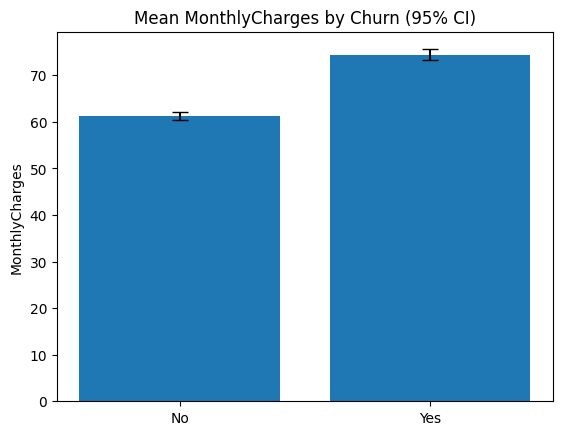

In [36]:
labels = means.index.tolist()
y = means.values
yerr_lower = y - np.array(CI_low)
yerr_upper = np.array(CI_high) - y

plt.bar(labels, y, yerr=[yerr_lower, yerr_upper], capsize=6)
plt.ylabel("MonthlyCharges")
plt.title("Mean MonthlyCharges by Churn (95% CI)")
plt.show()

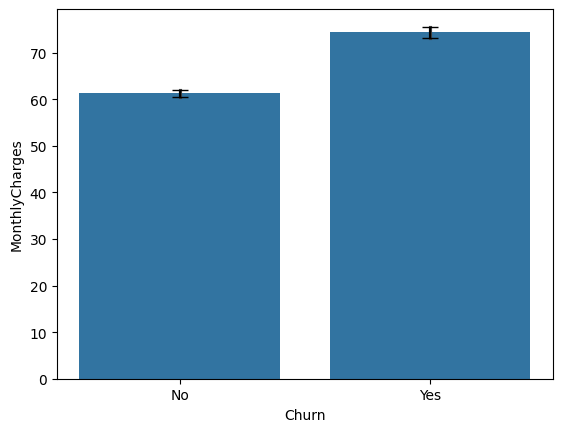

In [37]:
sns.barplot(data=customer_df, x='Churn', y='MonthlyCharges')
plt.errorbar(x=[0,1], y=y, yerr=[yerr_lower, yerr_upper], fmt='none', c='k', capsize=6)
plt.show()

In [38]:
customer_df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'gender_LE',
       'churn bin'],
      dtype='object')

### Moving on to another feature which results in predictive feature

In [39]:
customer_df.groupby('Churn')['tenure'].agg(['count', 'mean', 'median']).round(3)

,count,mean,median
Churn,,,
No,5174,37.570,38.0
Yes,1869,17.979,10.0


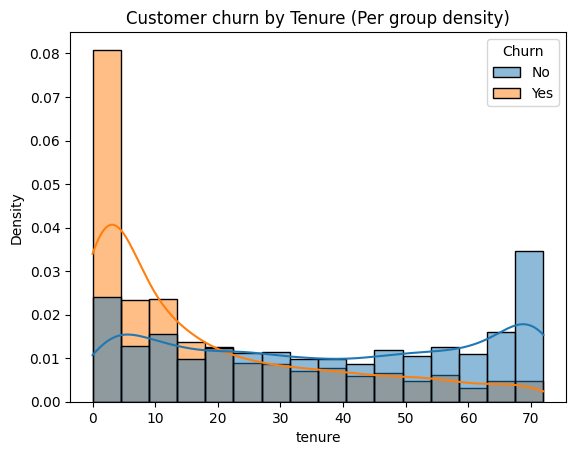

In [40]:
sns.histplot(data=customer_df, x='tenure', hue='Churn', kde=True,
             stat='density', common_norm=False)
plt.title("Customer churn by Tenure (Per group density)")
plt.show()

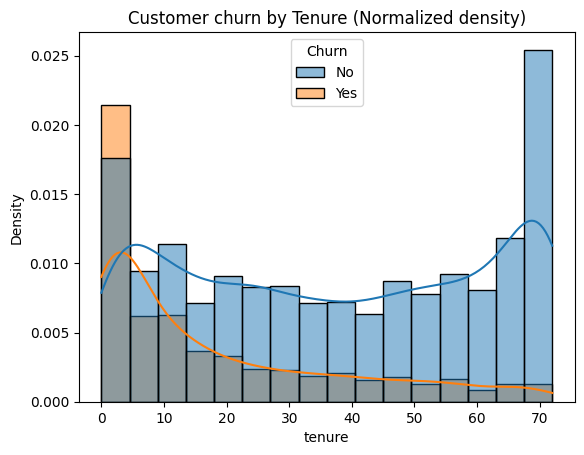

In [41]:
sns.histplot(data=customer_df, x='tenure', hue='Churn', kde=True,
             stat='density', common_norm=True)
plt.title("Customer churn by Tenure (Normalized density)")
plt.show()

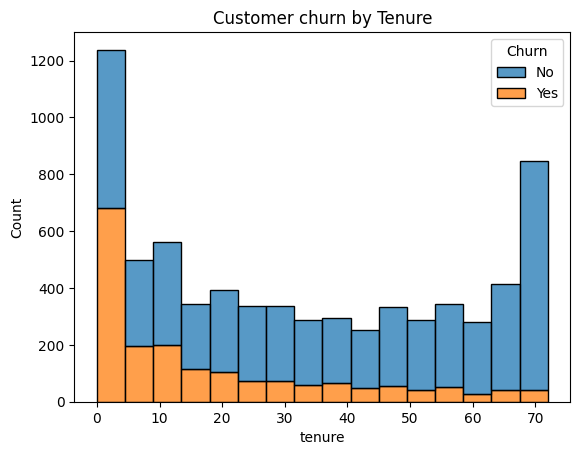

In [42]:
sns.histplot(data=customer_df, x='tenure', hue='Churn', kde=False,
             stat='count', multiple='stack')
plt.title("Customer churn by Tenure")
plt.show()

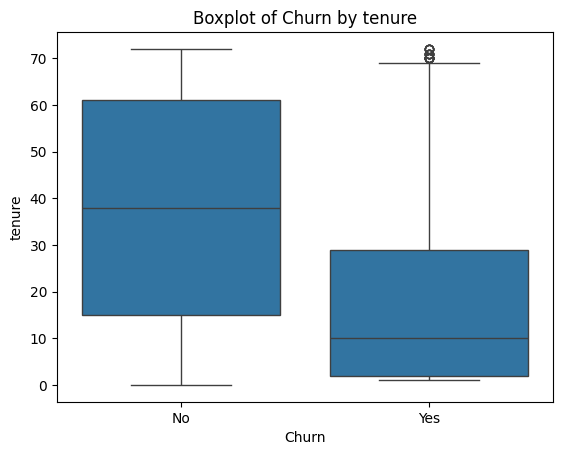

In [43]:
sns.boxplot(data=customer_df, x='Churn', y='tenure')
plt.title("Boxplot of Churn by tenure")
plt.show()

In [44]:
customer_df[(customer_df['tenure']==72) & (customer_df['Churn']=='Yes')]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender_LE,churn bin
3111,8809-RIHDD,Male,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,Yes,Two year,Yes,Electronic check,103.40,7372.65,Yes,1,1
3439,0917-EZOLA,Male,1,Yes,No,72,Yes,Yes,Fiber optic,No,...,Yes,Yes,Two year,Yes,Bank transfer (automatic),104.15,7689.95,Yes,1,1
3890,3886-CERTZ,Female,0,Yes,No,72,Yes,Yes,Fiber optic,No,...,Yes,Yes,One year,Yes,Electronic check,109.25,8109.8,Yes,0,1
4513,8580-QVLOC,Female,1,Yes,Yes,72,Yes,Yes,DSL,Yes,...,Yes,Yes,Two year,No,Credit card (automatic),92.45,6440.25,Yes,0,1
4610,2889-FPWRM,Male,0,Yes,No,72,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,One year,Yes,Bank transfer (automatic),117.80,8684.8,Yes,1,1
6424,6034-ZRYCV,Female,0,Yes,No,72,No,No phone service,DSL,No,...,Yes,Yes,Two year,Yes,Electronic check,54.20,3937.45,Yes,0,1


### Tenure Buckets

In [45]:
customer_df['tenure bin'] = pd.cut(customer_df['tenure'], bins=[0,3,6,12,18,24,48,99], labels=['0-3', '3-6', '6-12', '12-18', '18-24', '24-48', '48+'])
customer_df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender_LE,churn bin,tenure bin
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0,0,0-3
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,One year,No,Mailed check,56.95,1889.5,No,1,0,24-48
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,1,0-3
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,1,0,24-48
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0,1,0-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,One year,Yes,Mailed check,84.80,1990.5,No,1,0,18-24
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No,0,0,48+
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,Month-to-month,Yes,Electronic check,29.60,346.45,No,0,0,6-12
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes,1,1,3-6


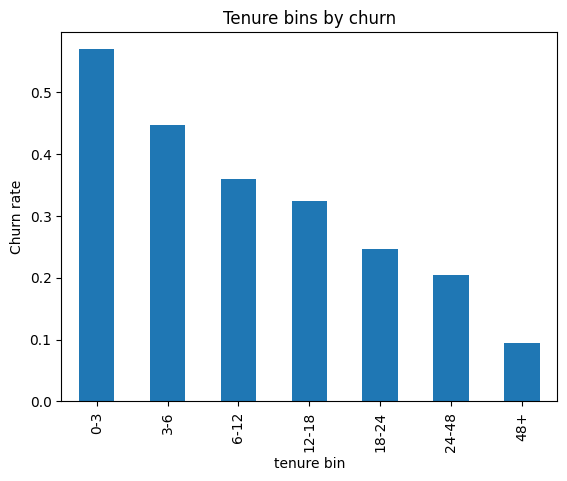

In [46]:
rate = customer_df.groupby('tenure bin', observed=True)['Churn'].apply(lambda s: (s=='Yes').mean())
rate.plot(kind='bar')
plt.title("Tenure bins by churn")
plt.ylabel("Churn rate")
plt.show()

In [47]:
ct = pd.crosstab(customer_df['tenure bin'], customer_df['Churn'])
ct

Churn,No,Yes
tenure bin,,
0-3,454,597
3-6,232,187
6-12,452,253
12-18,371,177
18-24,359,117
24-48,1269,325
48+,2026,213


In [48]:
chi2_tenure, p_tenure, dof_tenure, expected_tenure = chi2_contingency(ct)
print("Chi2 Tenure = %.3f p tenure = %.3f dof tenure = %.3f" % (chi2_tenure, p_tenure, dof_tenure))
print("Expected counts (if independent):\n", np.round(expected_tenure, 1))

Chi2 Tenure = 968.870 p tenure = 0.000 dof tenure = 6.000
Expected counts (if independent):
 [[ 771.7  279.3]
 [ 307.6  111.4]
 [ 517.6  187.4]
 [ 402.3  145.7]
 [ 349.5  126.5]
 [1170.3  423.7]
 [1643.9  595.1]]


<Axes: xlabel='tenure bin'>

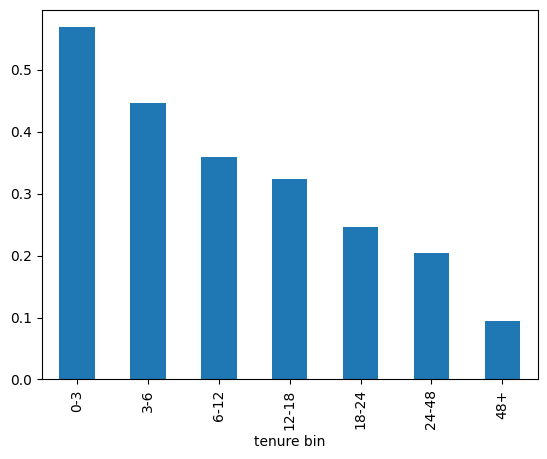

In [49]:
churn_rate = ct['Yes'] / ct.sum(axis=1)
churn_rate.plot(kind='bar')

# Taking residuals Observed and Expected

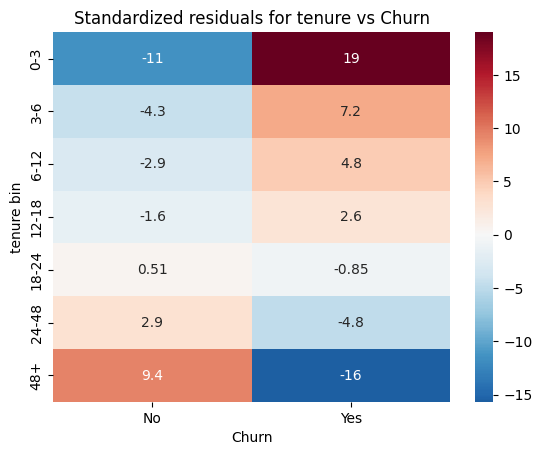

In [50]:
residuals_tenure = (ct - expected_tenure) / np.sqrt(expected_tenure)
sns.heatmap(residuals_tenure, annot=True, cmap='RdBu_r', center=0)
plt.title("Standardized residuals for tenure vs Churn")
plt.show()

In [51]:
def cramersV(chi2, n, r, c):
  return np.sqrt(chi2 / n * min(r-1,  c-1))

In [52]:
n_tenure = ct.to_numpy().sum()
r_tenure, c_tenure = ct.shape

Tenure_V = cramersV(chi2_tenure, n_tenure, r_tenure, c_tenure)
Tenure_V

np.float64(0.3711874463804873)

In [53]:
tenure_yes = customer_df[customer_df['Churn']=='Yes']['tenure'].dropna()
tenure_no = customer_df[customer_df['Churn']=='No']['tenure'].dropna()

skewness_tenure_no = skew(tenure_no)
skewness_tenure_yes = skew(tenure_yes)
print("Skewness of tenure with non churners:", skewness_tenure_no)
print("Skewness of tenure with churners:", skewness_tenure_yes)

Skewness of tenure with non churners: -0.031710670359456336
Skewness of tenure with churners: 1.148357706697273


### Testing for raw tenures

In [54]:
stats_tenure, p_tenure= levene(tenure_yes, tenure_no, center='median')
print("Tenure stats:", stats_tenure, '\n', "P Tenure:", p_tenure)
print("Rejecting null hypothesis of samples from populations having equal variance:", p_tenure < 0.05)

Tenure stats: 417.1696228201477 
 P Tenure: 3.963539602787529e-90
Rejecting null hypothesis of samples from populations having equal variance: True


### Welch's t-test (as vatiances differs)

In [55]:
t_test_tenure, p_ttest_tenure = ttest_ind(tenure_yes, tenure_no)
print("Welch's t-test for tenure (numerical):", t_test_tenure)
print("P value for t-test tenure:", p_ttest_tenure)
print("Rejecting null hypothesis for equal averages:", p_ttest_tenure < 0.005)

Welch's t-test for tenure (numerical): -31.57955051135377
P value for t-test tenure: 7.99905796059022e-205
Rejecting null hypothesis for equal averages: True


In [56]:
ct['total'] = ct.sum(axis=1)
ct['churn count'] = ct['Yes']
ct['churn rate'] = ct['churn count'] / ct['total']
ct

Churn,No,Yes,total,churn count,churn rate
tenure bin,,,,,
0-3,454,597,1051,597,0.568030
3-6,232,187,419,187,0.446301
6-12,452,253,705,253,0.358865
12-18,371,177,548,177,0.322993
18-24,359,117,476,117,0.245798
24-48,1269,325,1594,325,0.203890
48+,2026,213,2239,213,0.095132


In [57]:
from statsmodels.stats.proportion import proportion_confint

CI_tenure_bin = ct.apply(lambda row: proportion_confint(row['churn count'], row['total'],
                                                        method='wilson'), axis=1)
ct['CI low'] = [c[0] for c in CI_tenure_bin]
ct['CI high'] = [c[1] for c in CI_tenure_bin]
ct

Churn,No,Yes,total,churn count,churn rate,CI low,CI high
tenure bin,,,,,,,
0-3,454,597,1051,597,0.568030,0.537889,0.597677
3-6,232,187,419,187,0.446301,0.399404,0.494173
6-12,452,253,705,253,0.358865,0.324311,0.394950
12-18,371,177,548,177,0.322993,0.285190,0.363260
18-24,359,117,476,117,0.245798,0.209256,0.286411
24-48,1269,325,1594,325,0.203890,0.184834,0.224369
48+,2026,213,2239,213,0.095132,0.083663,0.107987


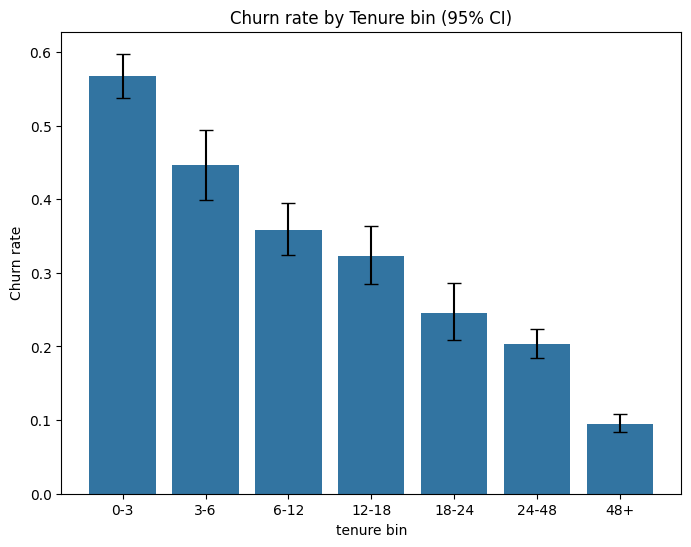

In [58]:
plt.figure(figsize=(8,6))
sns.barplot(x=ct.index, y=ct['churn rate'])
plt.errorbar(x=range(len(ct)), y=ct['churn rate'],
             yerr=[ct['churn rate'] - ct['CI low'], ct['CI high'] - ct['churn rate']],
             fmt='none', color='k', capsize=5)
plt.ylabel("Churn rate")
plt.title("Churn rate by Tenure bin (95% CI)")
plt.show()

## Insights:

From these insights of feature as `MonthlyCharges`, `Tenure`, it is clear that the churners are mostly from short term tenures and high charges. The reason for confirmation is that the mean differs a lot for MonthlyCharges and tenure in Churners and non-churners. The insight is confirmed from the statistical tests. Also the feature gender is not at all associated for churn. The genders (male and female) have means to be similar and variance or spread is almost similar.

## Looking onto other feature

In [59]:
customer_df['Contract'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

### Cross tabulation for contract with churn

In [60]:
ct_contract = pd.crosstab(customer_df['Contract'], customer_df['Churn'])
print(ct_contract)

Churn             No   Yes
Contract                  
Month-to-month  2220  1655
One year        1307   166
Two year        1647    48


In [61]:
chi2_contract, p_contract, dof_contract, expected_contract = chi2_contingency(ct_contract)
print("Chi2 test:", chi2_contract)
print("P value for contract: %.5f" % p_contract)
print("degrees of freedom:", dof_contract)
print("Expected counts for contract (if independent):", np.round(expected_contract, 1), '\n')
print("Rejecting null hypothesis of independent of contract and churn:", p_contract < 0.05)

Chi2 test: 1184.5965720837926
P value for contract: 0.00000
degrees of freedom: 2
Expected counts for contract (if independent): [[2846.7 1028.3]
 [1082.1  390.9]
 [1245.2  449.8]] 

Rejecting null hypothesis of independent of contract and churn: True


In [62]:
n_contract = ct_contract.to_numpy().sum()
r_contract, c_contract = ct_contract.shape

contract_V = cramersV(chi2_contract, n_contract,
                      r_contract, c_contract)
print("Cramer's V for strength or association of feature contract:", contract_V)

Cramer's V for strength or association of feature contract: 0.4101156965761409


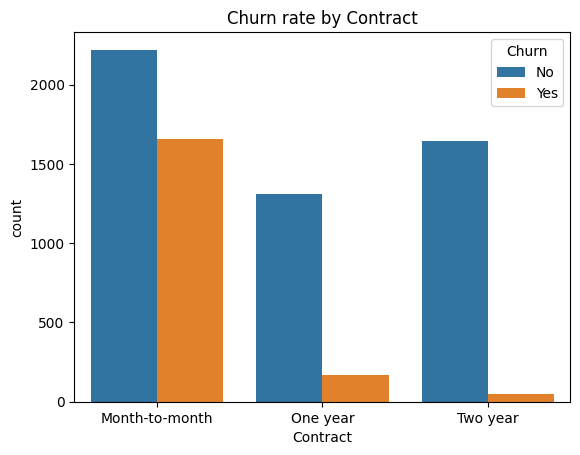

In [63]:
sns.countplot(x='Contract', hue='Churn', data=customer_df)
plt.title("Churn rate by Contract")
plt.show()

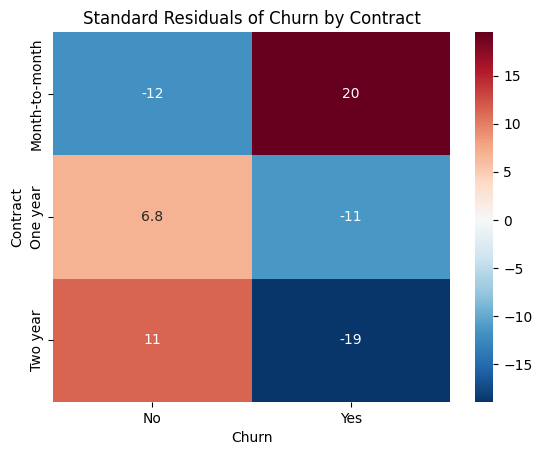

In [64]:
std_resid_contract = (ct_contract - expected_contract) / np.sqrt(expected_contract)
sns.heatmap(data=std_resid_contract, cmap='RdBu_r', annot=True, center=0)
plt.title("Standard Residuals of Churn by Contract")
plt.show()

## Computing churn rates and CIs of Contract

In [65]:
from statsmodels.stats.proportion import proportion_confint

In [66]:
ct_contract['total'] = ct_contract.sum(axis=1)
ct_contract['Churn count'] = ct_contract['Yes']
ct_contract['Churn rate'] = ct_contract['Churn count'] / ct_contract['total']

ct_contract

Churn,No,Yes,total,Churn count,Churn rate
Contract,,,,,
Month-to-month,2220,1655,3875,1655,0.427097
One year,1307,166,1473,166,0.112695
Two year,1647,48,1695,48,0.028319


#### Taking CI using wilson method

In [67]:
CI_contract = ct_contract.apply(lambda row: proportion_confint(row['Churn count'], row['total'],
                                method='wilson'), axis=1)

ct_contract['CI Low'] = [c[0] for c in CI_contract]
ct_contract['CI High'] = [c[1] for c in CI_contract]

print(ct_contract[['Churn rate', 'CI Low', 'CI High', 'total']])

Churn           Churn rate    CI Low   CI High  total
Contract                                             
Month-to-month    0.427097  0.411602  0.442736   3875
One year          0.112695  0.097544  0.129862   1473
Two year          0.028319  0.021425  0.037345   1695


### Plotting the CIs

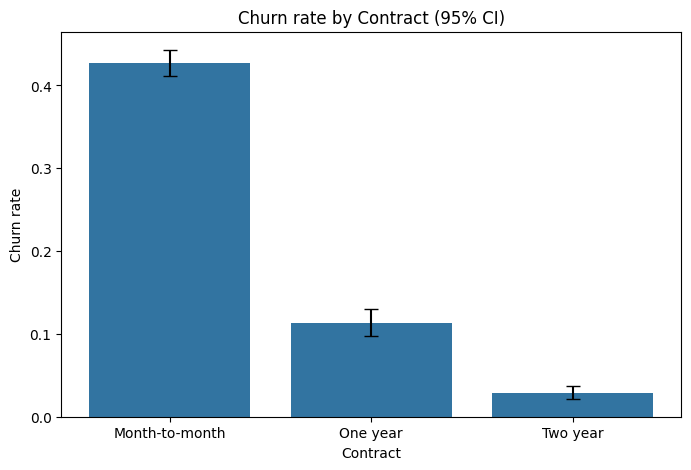

In [68]:
plt.figure(figsize=(8,5))
sns.barplot(x=ct_contract.index, y=ct_contract['Churn rate'])
plt.errorbar(x=range(len(ct_contract)), y=ct_contract['Churn rate'],
             yerr=[ct_contract['Churn rate'] - ct_contract['CI Low'],
                   ct_contract['CI High'] - ct_contract['Churn rate']],
             fmt='none', color='k', capsize=5)
plt.ylabel("Churn rate")
plt.title("Churn rate by Contract (95% CI)")
plt.show()

### Pairwise propotion tests

In [69]:
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests

contracts = ct_contract.index.tolist()
pairs = []
pvals = []
counts = []
nobs = []

for i in range(len(contracts)):
  for j in range(i+1, len(contracts)):
    c1, c2 = contracts[i], contracts[j]
    count = np.array([ct_contract.loc[c1, 'Churn count'], ct_contract.loc[c2, 'Churn count']])
    nobs_pair = np.array([ct_contract.loc[c1, 'total'], ct_contract.loc[c2, 'total']])
    stat_twoZ, p_twoZ = proportions_ztest(count, nobs_pair)
    pairs.append(f"{c1} vs {c2}")
    pvals.append(p_twoZ)
    counts.append(count)
    nobs.append(nobs_pair)

#### FDR correction

In [70]:
rej, p_adj, _, _ = multipletests(pvals, method='fdr_bh')
for pair, p, adjP, r in zip(pairs, pvals, p_adj, rej):
  print(pair, "P =", round(p, 4), "Adjusted p =", round(adjP, 4), "Significant or Not ?", r)

Month-to-month vs One year P = 0.0 Adjusted p = 0.0 Significant or Not ? True
Month-to-month vs Two year P = 0.0 Adjusted p = 0.0 Significant or Not ? True
One year vs Two year P = 0.0 Adjusted p = 0.0 Significant or Not ? True


###  95% Walds CI

In [71]:
z = 1.96

results = []
for pair, cnt, n in zip(pairs, counts, nobs):
  p1 = cnt[0]/ n[0]
  p2 = cnt[1]/ n[1]
  diff = p1 - p2
  SE = np.sqrt(p1*(1-p1)/n[0] + p2*(1-p2)/n[1])
  low, high = diff - z * SE, diff + z * SE
  results.append((pair, p1, p2, diff, low, high))

result_df = pd.DataFrame(results, columns=['pair', 'p1', 'p2', 'Difference', 'Low', 'high'])
print(result_df)

                         pair        p1        p2  Difference       Low  \
0  Month-to-month vs One year  0.427097  0.112695    0.314402  0.291966   
1  Month-to-month vs Two year  0.427097  0.028319    0.398778  0.381316   
2        One year vs Two year  0.112695  0.028319    0.084377  0.066400   

       high  
0  0.336837  
1  0.416241  
2  0.102353  


In [72]:
count1 = ct_contract.loc["Month-to-month", "Churn count"]
n1 = ct_contract.loc['Month-to-month', 'total']

count2 = ct_contract.loc["Two year", "Churn count"]
n2 = ct_contract.loc['Two year', 'total']


In [73]:

lo1, h1 = proportion_confint(count1, n1, method='wilson')
lo2, h2 = proportion_confint(count2, n2, method='wilson')

print(lo1, h1)

0.4116019532373783 0.4427359963802429


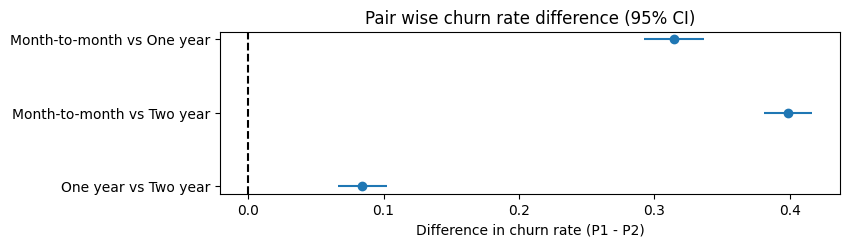

In [74]:
plt.figure(figsize=(8, len(result_df)*0.7))
y = np.arange(len(result_df))
plt.errorbar(result_df['Difference'], y, xerr=[result_df['Difference'] - result_df['Low'],
                                               result_df['high'] - result_df['Difference']],
             fmt='o')
plt.axvline(0, color='k', linestyle='--')
plt.yticks(y, result_df['pair'])
plt.xlabel("Difference in churn rate (P1 - P2)")
plt.gca().invert_yaxis()
plt.title("Pair wise churn rate difference (95% CI)")
plt.show()

### Insights:

Here as from Confidence Intervals(95%) it is clear that the month-month contract period is the most churners holding in. Using the chi square test, already found out that there is relationship between Contract and Churn. Also from Cramer's V with 0.3 suggests the strength is moderate. By taking the residuals it is noted about the observed vs expected. By taking CIs with each group of contract got the quantified analytics. When taking the pairwise z test to check the significant difference in churn rates and by multiple test correction it is cleared that churn rates differ. At the end it is clear about the month-to-month contract are having high churners when compared to two year or one year. Also it is noted that contract is a predictive feature

In [81]:
pd.set_option("display.max_column", None)
customer_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender_LE,churn bin,tenure bin
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0,0,0-3
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No,1,0,24-48
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,1,0-3
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,1,0,24-48
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0,1,0-3


In [75]:
customer_df['']